## **Packages installation :**

The swifter package is used to fasten our calculcation by parallelizing our processes that used the apply function from pandas

In [4]:
!pip install swifter

     |████████████████████████████████| 634kB 7.2MB/s 
     |████████████████████████████████| 471kB 11.2MB/s 
     |████████████████████████████████| 542kB 18.1MB/s 
     |████████████████████████████████| 102kB 7.1MB/s 
     |████████████████████████████████| 17.2MB 246kB/s 
     |████████████████████████████████| 23.1MB 117kB/s 
     |████████████████████████████████| 1.3MB 40.2MB/s 
     |████████████████████████████████| 204kB 56.3MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 133kB 51.7MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 2.9MB 44.6MB/s 
     |████████████████████████████████| 71kB 8.8MB/s 
     |████████████████████████████████| 143kB 49.1MB/s 
     |████████████████████████████████| 296kB 49.0MB/s 
     |████████████████████████████████| 61kB 5.6MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
  Created wheel for swifter: filename=swifter-1.0.7-cp36-n

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Paths :**

In [2]:
#input_file_path path to the folder containing the test and train sets
input_file_path = "/content/drive/MyDrive/Fact/Results/"
#output_file_path path for saving the Baseline results
output_file_path = "/content/drive/MyDrive/Fact/Results/parameters/BE/BE2/"

## **Imports :**

In [19]:
import pandas as pd
import numpy as np
import math
import pickle
import swifter
import matplotlib.pyplot as plt

## **Functions :**

In [ ]:
"""
Functions used to save object such as: dictionnaries (user and asset dictionnaries)
- Input:
obj: object to save
name: output filte name
path: path to the saving directory

"""
def save_obj(obj, name, path):
    with open(path + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
"""
load_obj:
- Input:
name: input filte name
path: path to the loading directory
- Output:
the loaded object
"""
def load_obj(name, path):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

## **Loading data :**

In [ ]:
interest_train = pd.read_csv(input_file_path + "interest_train.csv", index_col="index")
interest_test = pd.read_csv(input_file_path + "interest_test.csv", index_col="index")

In [ ]:
#we reset indexes to be able to extract mini batches using rows indexes
interest_train.reset_index(inplace=True, drop=True)
interest_test.reset_index(inplace=True, drop=True)

In [ ]:
interest_train

,id_profile,id_asset,rating,fui,rui
0,326534,202094,NaN,0.0,0.0
1,133318,5343689,NaN,0.0,0.0
2,1101174,86739,NaN,0.0,1.0
3,1264136,5349884,NaN,0.0,0.0
4,1093487,1547,NaN,0.0,0.0
...,...,...,...,...,...
51560975,221051,5300969,NaN,0.0,0.0
51560976,1688358,6635718,NaN,0.0,0.0
51560977,335210,4866597,NaN,0.0,0.0
51560978,614980,435552,NaN,0.0,0.0


## **setting up parameters:**
For the average rating calculation we decided to only keep the non null ratings, doing so give a more relevant rating than taking evry row into account (which gave us an average rating close to 0).<br>
We set up an index for each user and asset, that we save into dictionnaries. Those indexes will be used to keep track of each **user bu** and **each asset bi**.
 

In [ ]:
# mu is the overall average rating,
mu = interest_train[~interest_train["rating"].isnull()]["rating"].mean()
# getting unique users and assets from the train set
unique_users = interest_train["id_profile"].unique()
unique_assets = interest_train["id_asset"].unique()

#keeping track of number of: users, n_asset, n_rows of traing set
n_users = len(unique_users)
n_asset = len(unique_assets)
n_rows = len(interest_train)


#getting the users and assets indexes as dictionnaries
idx_users = {y: x for x,y in enumerate(unique_users)}
idx_assets = {y: x for x,y in enumerate(unique_assets)}

#saving the dictionnaries of indexes and average rating
save_obj(idx_users, "idx_users", output_file_path)
save_obj(idx_assets, "idx_assets", output_file_path)
np.save(output_file_path + "/mu.npy", mu)

#setting the batch size, if experiencing ram shortage try reducing batch size
BATCH_SIZE = 512


## **Baseline Estime class :**
We chose to implement the basline model through a class that contain several method to keep our work well organized.<br>
As mentionned in the original paper, most of the time customers feedback data have tendencies to have users that give higher or lower ratings than others and assets that receive higher or lower rating than others. The basline estimate method is a simple way that tries to adjust this effect using the following function :

\begin{equation}
b_{ui} = \mu + b_u + b_i
\end{equation}

The parameters Bu and Bi are the parameters that we have to train which indicates the ovserved deviation of user U and item I from the average.
Estimates of Bu and Bi are obtained by the minimization of the regularized MSE loss function :

\begin{equation}
\sum_{(u,i) \in \mathcal{K}} (r_{ui} - b_{ui})^2 + \lambda_1 \left( \sum_{u} b_u^2 + \sum_{i} b_i^2 \right),
\end{equation}

To minimize the loss we used mini batch gradient descent method as a way to optimize memory consumption and fasten calculation. Bellow the derivative with respect to each parameter Bu and Bi:<br>
Bu derivative :
\begin{equation}
\sum_{(i) \in \mathcal{R(u)}} -2* (r_{ui} - b_{ui}) + 2* \lambda_1 ( b_u ),
\end{equation}
Bi derivative :
\begin{equation}
\sum_{(u) \in \mathcal{W(i)}} -2* (r_{ui} - b_{ui}) + 2* \lambda_1 ( b_i ),
\end{equation}

Here R(u) is the set of item rated by user u and W(i) is the set of user that rated the item i.

In our final implementation we vectorized the derivatives calculation which means that we calculate the gradient with respect to the loss function for each mini batch of bu and bi parameters that were found in mini batch row.

In [ ]:
class Baseline_Estimate:
  """
  Init function to initialize the baseline estimate object
  - Input:
  train_dataset: training dataset
  mu: average rating
  idx_users: dictionnary containing user indexes
  idx_assets: dictionnary containing asset indexes
  Bi: (Optionnal) assets weights should be of same size as number of unique assets, default None will be initialized to random at training 
  Bu: (Optionnal)  users weights should be of same size as number of unique users, default None will be initialized to random at training,
  losses: (Optionnal) keep track of loss initialized at []
  BATCH_SIZE: (Optionnal)
  seed:(Optionnal) to keep same results

  """
  def __init__(self, train_dataset, mu,idx_users, idx_assets, Bi = None, Bu = None,
               losses= [], BATCH_SIZE=2048,seed=123):
    np.random.seed(seed)
    self.BATCH_SIZE = BATCH_SIZE
    self.train_dataset = train_dataset
    self.Bu = Bu
    self.Bi = Bi
    self.mu = mu
    self.losses = losses
    # counting the number of rows 
    self.n_rows = train_dataset.shape[0]
    # counting the number of batches 
    self.n_batches = math.ceil(self.n_rows/BATCH_SIZE)
    self.idx_users = idx_users
    self.idx_assets = idx_assets

  """
  Train function to train the baseline model
  - Input:
  epochs: number of epochs 
  path_to_file: (optionnal) if set it will save parameters and loss in the specified directory path
  save_every: (optionnal) if path_to_file is set, save_every indicates the epochs saving frequency
  lr: (optionnal) learning rate
  reg_lambda: (optionnal) regularization term
  current_epoch: (optionnal) if we want to resume training using loaded weights.
  -Output:
  losses: list of loss per epoch
  """
  def train(self, epochs,path_to_file = "", current_epoch=1, lr = 0.025, reg_lambda = 0.02, save_every=1):
    if(self.Bu is None):
      self.Bu = np.random.normal(0,  0.2, size=n_users)
    if(self.Bi is None):
      self.Bi = np.random.normal(0, 0.2, size=n_asset)


    rui = np.asarray(self.train_dataset["rui"])
    mu = self.mu
    
    for i in range(current_epoch-1, epochs):
      print("")
      print("-------------------------------------")
      print("EPOCH :", i+1)
      self.Bu, self.Bi = self.compute_one_epoch(self.Bu,self.Bi,
                                                self.BATCH_SIZE,self.n_batches,self.n_rows,
                                                self.train_dataset, self.mu,reg_lambda,lr)
      print("")
      print("computing loss : ")
      
      loss, reg_loss = self.compute_loss(self.Bu, self.Bi, self.BATCH_SIZE, self.n_batches,self.n_rows, self.train_dataset, self.mu)
      print("")
      print("Current epoch loss :", loss, "regularized_loss :", reg_loss)
      self.losses.append(reg_loss)
      if((i + 1)%save_every == 0):
        if(path_to_file):
          #saving parameter bi, bu and losses
          np.save (path_to_file + "bi_" + str(i+1) + ".npy",self.Bi)
          np.save(path_to_file + "bu_" + str(i+1) + ".npy", self.Bu)
          np.save(path_to_file + "losses.npy", self.losses)
    return self.losses



  """
  compute_loss: used to compute loss.

  - Input:
  Bu:(Optionnal) Bu parameters if set up to None will use the object intialized parameter
  Bi:(Optionnal) Bi parameters if set up to None will use the object intialized parameter
  BATCH_SIZE:(Optionnal) batch size if set up to None will use the object intialized parameter
  n_batches:(Optionnal) number of batches if set up to None will use the object intialized parameter
  n_rows:(Optionnal) number of rows if set up to None will use the object intialized parameter
  dataset:(Optionnal) as a pandas dataframe if set up to None will use the object intialized parameter
  mu:(Optionnal) average rating if set up to None will use the object intialized parameter
  reg_lambda: (optionnal) regularization 
  dataset_percent: (optionnal) percent of the given data set that will be used to compute loss, 1 = 100%

  -Output:
  no_reg_loss: loss without regularization
  loss_regularized: regularized loss
  """
  def compute_loss(self, Bu=None,Bi=None,BATCH_SIZE=None,n_batches=None, n_rows=None, dataset=None, mu=None,reg_lambda = 0.02, dataset_percent=0.1):
    
    # parameter initialization
    if (dataset is None):
      dataset=self.train_dataset
      BATCH_SIZE= self.BATCH_SIZE
      n_batches= self.n_batches
      n_rows= self.n_rows
    else:
      if (BATCH_SIZE == None):
        BATCH_SIZE = self.BATCH_SIZE

      n_rows = dataset.shape[0]
      n_batches = math.ceil(n_rows/BATCH_SIZE)
      
      
      
    if (mu == None):
      mu= self.mu

    if (Bu is None):
      Bu= self.Bu
    if (Bi is None):
      Bi= self.Bi

    shuffled_idx = np.asarray(dataset.index)
    
    # number of sample initialization will be incremanted for each row used in the minibatch computation
    n_sample = 0
    # for regularization 
    Bu_pow_sum = sum(np.power(Bu,2))
    Bi_pow_sum = sum(np.power(Bi,2))
    #loss: the overall loss sum
    loss = 0

    # iterating over all batches to compute one epoch
    for i in range(math.floor(n_batches*dataset_percent)):
      start = i*BATCH_SIZE
      end = (i + 1)*BATCH_SIZE
      if end > n_rows:
        end = n_rows
      # extract one mini batch
      sub_df = dataset.iloc[shuffled_idx[start:end]]
      #incrementing number of sample
      n_sample += sub_df.shape[0]

      #creating a pivot matrix of size ( number of uniqueUsers in mini batch * number of uniqueAssets in mini batch)
      pivot_df = sub_df.pivot(index='id_profile', columns='id_asset', values='rui')
      pivot_array = pivot_df.to_numpy()



      #sub_u id (id_profile) of each user contained in the minibatch
      sub_u = pivot_df.index.to_numpy()
      #sub_u id (id_asset) of each asset contained in the minibatch
      sub_i = pivot_df.columns.to_numpy()

      #extracting the related index of each user
      bu_idx = np.asarray([self.idx_users[x] for x in sub_u])
      #extracting the related index of each asset
      bi_idx = np.asarray([self.idx_assets[x] for x in sub_i])

      #extracted the related Bu wight of each user that will be optimized during this mini batch computation
      sub_bu = Bu[bu_idx]
      #extracted the related Bi wight of each asset that will be optimized during this mini batch computation
      sub_bi = Bi[bi_idx]

      #Creating the rui matrix from the pivot array mini batch
      bubi_rui = np.nan_to_num(pivot_array)
      #Creating the bubi_found matrix that would be used to only take into account known comnination of user and asset in the minibatch
      # if user asset combination is found = 1 else 0
      bubi_found = pivot_array
      bubi_found[~np.isnan(bubi_found)] = 1
      bubi_found = np.nan_to_num(bubi_found)
     
      # caluculating the predicted bui for each (user,asset) combination in the minibatch
      bui_mat = bubi_found.copy()

      bui_mat[bui_mat == 1] = mu

      bui_mat = bui_mat + sub_bu[:, None]
      bui_mat = bui_mat + sub_bi
      #calculating the loss for each (user,asset) combination in the minibatch
      loss_mat = np.power(np.subtract(bubi_rui,bui_mat),2)
      #setting to 0 the loss for all the non existing (user,asset) combination (that should not be taken into account) 
      loss_mat[bubi_found == 0] = 0
      #adding the loss to the overall loss
      loss += loss_mat.sum()

      
      if(i%(math.ceil(n_batches*0.1*dataset_percent)) == 0):
        print(str(math.floor(100*i/(n_batches*dataset_percent))),"% treated")
    #averaging the loss
    no_reg_loss = loss/n_sample
    #adding regularization term
    loss_regularized = (loss + reg_lambda*(Bu_pow_sum + Bi_pow_sum))/n_sample
    return no_reg_loss, loss_regularized

  """
  Compute_one_epoch: used to compute one epoch of training on all the dataset

  - Input:
  Bu: Bu parameters that will be updated 
  Bi: Bi parameters that will be updated 
  BATCH_SIZE: batch size
  n_batches: number of batches
  n_rows: number of rows
  dataset: training dataset as a pandas dataframe
  mu: average rating
  reg_lambda: (optionnal) regularization parameter
  lr: (optionnal) learning rate

  -Output:
  Bu: updated Bu
  Bi: updated Bi
  """
  def compute_one_epoch(self, Bu,Bi,BATCH_SIZE,n_batches,n_rows,dataset, mu,reg_lambda = 0.02,lr=0.025):
    # shuffle the index on each new epoch
    shuffled_idx = np.asarray(dataset.index)
    np.random.shuffle(shuffled_idx)

    # iterating over all batches to compute one epoch
    for i in range(n_batches):
      start = i*BATCH_SIZE
      end = (i + 1)*BATCH_SIZE
      if end > n_rows:
        end = n_rows
      # extract one mini batch  
      sub_df = dataset.iloc[shuffled_idx[start:end]]


      #creating a pivot matrix of size ( number of uniqueUsers in mini batch * number of uniqueAssets in mini batch)
      pivot_df = sub_df.pivot(index='id_profile', columns='id_asset', values='rui')
      pivot_array = pivot_df.to_numpy()




      #sub_u id (id_profile) of each user contained in the minibatch
      sub_u = pivot_df.index.to_numpy()
      #sub_i id (id_asset) of each asset contained in the minibatch
      sub_i = pivot_df.columns.to_numpy()

      #extracting the related index of each user   
      bu_idx = np.asarray([self.idx_users[x] for x in sub_u])
      #extracting the related index of each asset
      bi_idx = np.asarray([self.idx_assets[x] for x in sub_i])

      #extracted the related Bu weight of each user that will be optimized during this mini batch computation
      sub_bu = Bu[bu_idx]
      #extracted the related Bi weight of each asset that will be optimized during this mini batch computation
      sub_bi = Bi[bi_idx]
      
      #Creating the rui matrix from the pivot array mini batch
      bubi_rui = np.nan_to_num(pivot_array)
      #Creating the bubi_found matrix that would be used to only take into account known comnination of user and asset in the minibatch
      # if user asset combination is found = 1 else 0
      bubi_found = pivot_array
      bubi_found[~np.isnan(bubi_found)] = 1
      bubi_found = np.nan_to_num(bubi_found)

    
      # size (number of unique users in minibatch) contain the sum of rui for each user
      user_rui_sum = bubi_rui.sum(1)
      # size (number of unique assets in minibatch) contain the sum of rui for each asset
      asset_rui_sum = bubi_rui.sum(0)

      # size (number of unique users in minibatch) contain the number of asset seen by user on the minibatch
      user_participation = bubi_found.sum(1)
      # size (number of unique assets in minibatch) contain the number of user that have seen the concerned asset on the minibatch
      asset_parcipation = bubi_found.sum(0)

      #calculating the loss gradient with respect to bu for this minibatch
      bu_grads = -2.0*(user_rui_sum - user_participation*(self.mu  +  sub_bu) - bubi_found.dot(sub_bi)) + 2.0*reg_lambda*sub_bu

      #update bu
      sub_bu_next = sub_bu - lr*bu_grads 

      #calculating the loss gradient with respect to bi for this minibatch
      bi_grads = -2.0*(asset_rui_sum - asset_parcipation*(self.mu + sub_bi) - bubi_found.T.dot(sub_bu)) + 2.0*reg_lambda*sub_bi

      #update bi
      sub_bi_next = sub_bi - lr*bi_grads

      #updating Bu and Bi using the indexes 
      Bu[bu_idx] = sub_bu_next
      Bi[bi_idx] = sub_bi_next

      if(i%(math.ceil(n_batches*0.1)) == 0):
        print(str(math.floor(100*i/n_batches)),"% treated")
      
    return Bu, Bi


  """
  predict: used to predict bui.

  - Input:
  Bu:(Optionnal) Bu parameters if set up to None will use the object intialized parameter
  Bi:(Optionnal) Bi parameters if set up to None will use the object intialized parameter
  BATCH_SIZE:(Optionnal) batch size if set up to None will use the object intialized parameter
  n_batches:(Optionnal) number of batches if set up to None will use the object intialized parameter
  n_rows:(Optionnal) number of rows if set up to None will use the object intialized parameter
  dataset:(Optionnal) as a pandas dataframe if set up to None will use the object intialized parameter
  mu:(Optionnal) average rating if set up to None will use the object intialized parameter
  reg_lambda: (optionnal) regularization 
  
  -Output:
  no_reg_loss: loss without regularization
  loss_regularized: regularized loss
  result: list of predicted bui
  """
  def predict(self, dataset=None, Bu=None,Bi=None,BATCH_SIZE=None,n_batches=None, n_rows=None, mu=None,reg_lambda = 0.02):
    #parameter initialization
    if (dataset is None):
      dataset=self.train_dataset
      BATCH_SIZE= self.BATCH_SIZE
      n_batches= self.n_batches
      n_rows= self.n_rows
    else:
      if (BATCH_SIZE == None):
        BATCH_SIZE = self.BATCH_SIZE

      n_rows = dataset.shape[0]
      n_batches = math.ceil(self.n_rows/BATCH_SIZE)
      
      
      
    if (mu == None):
      mu= self.mu

    if (Bu is None):
      Bu= self.Bu
    if (Bi is None):
      Bi= self.Bi



    shuffled_idx = np.asarray(dataset.index)

    # number of sample initialization will be incremanted for each row used in the minibatch computation
    n_sample = 0
    # for regularization 
    Bu_pow_sum = sum(np.power(Bu,2))
    Bi_pow_sum = sum(np.power(Bi,2))
    #loss: the overall loss sum
    loss = 0
    #list of BUI preciction 
    results = []
    #iterating over all batches
    for i in range(n_batches):
      start = i*BATCH_SIZE
      end = (i + 1)*BATCH_SIZE
      if end > n_rows:
        end = n_rows
      
      #extracting mini batch
      sub_df = dataset.iloc[shuffled_idx[start:end]]
      #incrementing number of samples
      n_sample += sub_df.shape[0]

      #creating a pivot matrix of size ( number of uniqueUsers in mini batch * number of uniqueAssets in mini batch)
      pivot_df = sub_df.pivot(index='id_profile', columns='id_asset', values='rui')
      pivot_array = pivot_df.to_numpy()

      #extracting user bu index for each user in the minibatch, list of size (number of rows in minibatch)
      user_bu_id = sub_df["id_profile"].swifter.progress_bar(False).apply(lambda x: self.idx_users[x]).to_numpy()
      #extracting asset bi index for each asset in the minibatch, list of size (number of rows in minibatch)
      asset_bi_id = sub_df["id_asset"].swifter.progress_bar(False).apply(lambda x: self.idx_assets[x]).to_numpy()

      #calculat bui for each row (make prediction)
      bui = mu + Bu[user_bu_id] + Bi[asset_bi_id]

      #extracting rui for each row (real value)
      rui = sub_df["rui"].to_numpy()

      #calculating loss and adding to the overall loss
      loss += np.power(rui - bui, 2).sum()
      #appendig result prediction
      results = np.append(results, bui) 


      
      if(i%(math.ceil(n_batches*0.1)) == 0):
        print(str(math.floor(100*i/(n_batches))),"% treated")
    #averaging the loss
    no_reg_loss = loss/n_sample
    #adding regularization
    loss_regularized = (loss + reg_lambda*(Bu_pow_sum + Bi_pow_sum))/n_sample
    return no_reg_loss, loss_regularized, results



## **load model :**

In [ ]:
be = Baseline_Estimate(interest_train,mu,idx_users,idx_assets, BATCH_SIZE=BATCH_SIZE)

## **train and save model :**

In [ ]:
be.train(path_to_file=output_file_path,epochs=15,save_every=1)


-------------------------------------
EPOCH : 1
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated

computing loss : 
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated

Current epoch loss : 0.8015411132545857 regularized_loss : 0.8166669323074526

-------------------------------------
EPOCH : 2
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated

computing loss : 
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated

Current epoch loss : 0.5728380332219379 regularized_loss : 0.5937747230168038

-------------------------------------
EPOCH : 3
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated

computing l

[0.8166669323074526,
 0.5937747230168038,
 0.5071768403378855,
 0.47050461624832296,
 0.443865848803974,
 0.4291066774095143,
 0.4197215051023447,
 0.4121253713954268,
 0.40782006302850415,
 0.39897839493312814,
 0.39724915816757606,
 0.39496773156005055,
 0.39106453289095616,
 0.38887366645845955,
 0.38759628129694446]

## **Computing test loss on each epoch :**

In [ ]:
test_loss = []
mu = np.load(output_file_path + "mu" + ".npy")
BATCH_SIZE=512
idx_users = load_obj("idx_users", output_file_path)
idx_assets = load_obj("idx_assets",output_file_path)
BATCH_SIZE
for i in range(15):
  print("test EPOCH " + str(i+1))
  Bu = np.load(output_file_path + "/bu_" + str(i+1) + ".npy")
  Bi = np.load(output_file_path + "/bi_" + str(i+1) + ".npy")

  losses = np.load(output_file_path + "losses.npy")
  be = Baseline_Estimate(interest_train,mu,idx_users,idx_assets,Bi=Bi,Bu=Bu,losses=losses, BATCH_SIZE=BATCH_SIZE)
  no_reg_loss, loss_regularized = be.compute_loss(dataset=interest_test, dataset_percent=1)
  test_loss.append(loss_regularized)

np.save(output_file_path + "/test_losses.npy", test_loss)

test EPOCH 1
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated
test EPOCH 2
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated
test EPOCH 3
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated
test EPOCH 4
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated
test EPOCH 5
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated
test EPOCH 6
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated
test EPOCH 7
0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated
test E

## **Plot test and train loss on each epoch :**

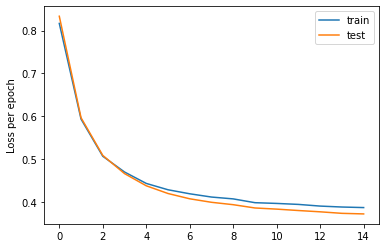

In [16]:
import matplotlib.patches as mpatches

#loading test and train loss
test_loss = np.load(output_file_path + "test_losses.npy").tolist()
loss = np.load(output_file_path + "losses.npy").tolist()

plt.plot(loss, label="train")
plt.plot(test_loss, label="test")
plt.ylabel('Loss per epoch')
plt.legend()
plt.show()

In [17]:
bestResult_Index = np.argmin(loss) + 1
bestResult_MSE_Loss_train = np.min(loss)
bestResult_RMSE_Loss_train = np.sqrt(bestResult_MSE_Loss_train)

print("Best epoch result on train set : {}".format(bestResult_Index))
print("MSE loss on train set : {}".format(bestResult_MSE_Loss_train))
print("RMSE loss on train set : {}".format(bestResult_RMSE_Loss_train))

Best epoch result on train set : 15
MSE loss on train set : 0.38759628129694446
RMSE loss on train set : 0.6225723100949354


In [18]:
bestResult_Index = np.argmin(test_loss) + 1
bestResult_MSE_Loss_test = np.min(test_loss)
bestResult_RMSE_Loss_test = np.sqrt(bestResult_MSE_Loss_test)

print("Best epoch result : {}".format(bestResult_Index))
print("MSE loss : {}".format(bestResult_MSE_Loss_test))
print("RMSE loss : {}".format(bestResult_RMSE_Loss_test))


Best epoch result : 15
MSE loss : 0.37281676243973666
RMSE loss : 0.610587227543892


## **Make Predictions :**

In [ ]:
#making prediction over the first 1000 rows from test set
_, _, results = be.predict(dataset=interest_test.head(1000), BATCH_SIZE=4096,reg_lambda = 0.02)

0 % treated
10 % treated
20 % treated
30 % treated
40 % treated
50 % treated
60 % treated
70 % treated
80 % treated
90 % treated


## **Exemple of loading a specific epoch parameters :**

In [ ]:
epoch=10

Bu = np.load(output_file_path + "/bu_" + str(epoch) + ".npy")
Bi = np.load(output_file_path + "/bi_" + str(epoch) + ".npy")
losses = np.load(output_file_path + "losses.npy")
losses= losses[0:epoch]
mu = np.load(output_file_path + "mu" + ".npy")
BATCH_SIZE=512
idx_users = load_obj("idx_users", output_file_path)
idx_assets = load_obj("idx_assets",output_file_path)


#creating baseline object
be = Baseline_Estimate(interest_train,mu,idx_users,idx_assets,Bi=Bi,Bu=Bu,losses=losses, BATCH_SIZE=BATCH_SIZE)

